# To do
1. Zoom into taxi maps
2. More fine-tuned estimates of traffic speeds by using segment data (https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/77hq-huss) rather than region data.
3. Analyze Near North in the same way as the Loop
4. Use Taxi ID to see travel patterns for single taxis on a given day, e.g. distribution of number of pickup/dropoff at busy areas in a day.
5. Figure out bus tracker glitch.

# Motivation
As in many other major cities, traffic in Chicago can be treacherous at peak times. Bad traffic is an example of a tragedy of the commons problem. Individuals take advantage of a shared resource (roads), which is provided at very low cost, in a way that they each perceive to be best for their own self-interest. The result is an overuse of the resource, leading to reduced utility for everyone.

There are many ways to tackle such a problem, but one solution for bad traffic that is popular among urban economists is road pricing. The basic idea of road pricing is to impose a fee on the use of the streets when itt results in lost time for others; in econ-lingo, this tries to price in the externalities of using the roads at peak times. Many of the cars in the problematic downtown areas are taxis and, increasingly, ride-hailing services like Uber and Lyft. The preferred result of road pricing is to nudge people into using public transport rather than getting on cars individually, so that they can travel more efficiently in terms of occupied road space.

The goal of the following analysis is to determine which areas at what times may benefit the most from such an intervention, and to explore what kinds of pricing scheme would be most effective. Main source of the data is Taxi Trips data from 2013 to now (https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew). Unfortunately, there is no large public dataset of Uber and Lyft usage in Chicago. My working assumption for now is that taxi usage will be a good proxy for ride-hailing service usage, especially in downtown areas where taxis are easy to find on the street. I will also use other smaller datasets at the Chicago Data Portal (https://data.cityofchicago.org), and will note each appearance of such data.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## When and where is traffic bad?
First, I will look at which areas in Chicago have the worst traffic problems. Past congestion data, from bus tracking, is at https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/emtn-qqdi.

Unfortunately, this dataset hasn't been updated since 2015 (there is a live tracking feed for current conditions). Also, there are big glitches where the data from 2015 are all labeled as being from January, and all data from 2013 and 2014 are labeled as being taken at 11pm. I have used the 2015 data, assuming that the entries are essentially correct aside from the month and that the data is still representative of the traffic patterns.

Region ID correspondence is given at https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Re/t2qc-9pjd.

The bus tracking data has some serious glitches that needed correcting for. See the last section on data cleaning where this is addressed.

In [35]:
#Look at historical congestion data
df_cong = pd.read_csv('Data/Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Region.csv')

In [46]:
#Parse TIME
cong_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')
df_cong['TIME'] = df_cong['TIME'].apply(cong_parser)

In [48]:
df_cong['year'] = df_cong['TIME'].apply(lambda x: x.year)
df_cong['hour'] = df_cong['TIME'].apply(lambda x: x.hour)
df_cong['weekday'] = df_cong['TIME'].apply(lambda x: x.weekday() < 5) #True if weekday

In [159]:
#Limit myself to the clean part of the data set
df_cong_clean = df_cong.iloc[:129427]

Make plots of average bus speeds by hour, for 4 centrally located areas. Plot overall average, weekday average, then weekends.

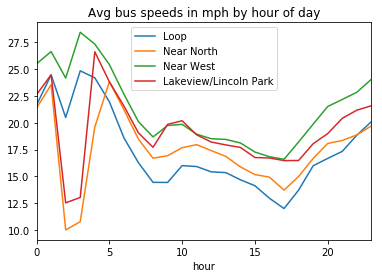

In [168]:
df_cong_clean[(df_cong_clean.REGION_ID == 13)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong_clean[(df_cong_clean.REGION_ID == 12)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong_clean[(df_cong_clean.REGION_ID == 11)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong_clean[(df_cong_clean.REGION_ID == 8)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview

plt.title('Avg bus speeds in mph by hour of day')
plt.legend()
plt.savefig('Figs/bus_speed.png')
plt.show()

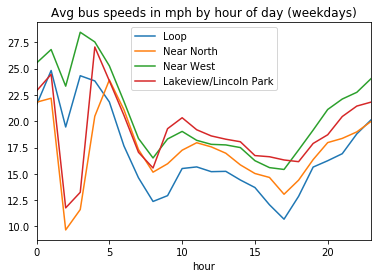

In [169]:
df_cong_clean[(df_cong_clean.weekday == True) & (df_cong_clean.REGION_ID == 13)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong_clean[(df_cong_clean.weekday == True) & (df_cong_clean.REGION_ID == 12)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong_clean[(df_cong_clean.weekday == True) & (df_cong_clean.REGION_ID == 11)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong_clean[(df_cong_clean.weekday == True) & (df_cong_clean.REGION_ID == 8)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview

plt.title('Avg bus speeds in mph by hour of day (weekdays)')
plt.legend()
plt.savefig('Figs/weekday_bus_speed.png')
plt.show()

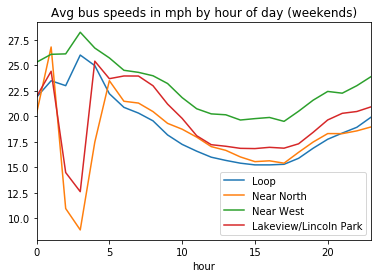

In [170]:
df_cong_clean[(df_cong_clean.weekday == False) & (df_cong_clean.REGION_ID == 13)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong_clean[(df_cong_clean.weekday == False) & (df_cong_clean.REGION_ID == 12)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong_clean[(df_cong_clean.weekday == False) & (df_cong_clean.REGION_ID == 11)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong_clean[(df_cong_clean.weekday == False) & (df_cong_clean.REGION_ID == 8)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview

plt.title('Avg bus speeds in mph by hour of day (weekends)')
plt.legend()
plt.savefig('Figs/weekend_bus_speed.png')
plt.show()

The dips in early morning appear because very few buses are being tracked; some rows show 0.0 as the average speed. These are artifacts of the data taking process and is not indicative of the traffic condition.

Some features in the weekday plot are obvious if you spend any time in the city:
1. There is a small dip at 8-9am for the morning commute.
2. There is a deeper dip around 5pm.

The Loop is identified as uniquely congested (no surprise), with Near North firmly in second place.

Comparing also with plots for 2 other, less central areas (shown below) shows that Near West and Lakeview/Lincoln Park are not especially congested in relation to them, which is mildly surprising. The notable features for them are the slightly busier afternoon commutes for Near West, and larger nighttime and weekend activities in Lakeview/Lincoln Park.

These are statements about average speeds, and it is an open question whether areas outside the top 2 experience episodic bad traffic that may require a deeper look. Event traffic (e.g. Cubs home games in Lakeview) can be significant for short periods of time.

Nevertheless, the first focus should be the Loop, and late afternoon/early evening around 4-7pm.

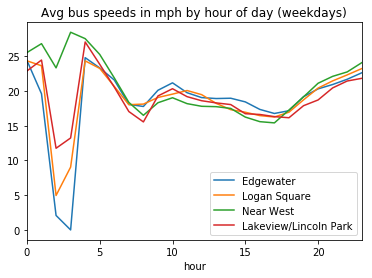

In [171]:
df_cong_clean[(df_cong_clean.weekday == True) & (df_cong_clean.REGION_ID == 4)].groupby('hour').mean()['SPEED'].plot(label='Edgewater') #Edgewater
df_cong_clean[(df_cong_clean.weekday == True) & (df_cong_clean.REGION_ID == 7)].groupby('hour').mean()['SPEED'].plot(label='Logan Square') #Logan Square
df_cong_clean[(df_cong_clean.weekday == True) & (df_cong_clean.REGION_ID == 11)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong_clean[(df_cong_clean.weekday == True) & (df_cong_clean.REGION_ID == 8)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview

plt.title('Avg bus speeds in mph by hour of day (weekdays)')
plt.legend()
plt.savefig('Figs/weekday_comparison.png')
plt.show()

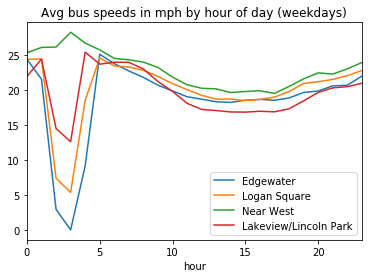

In [173]:
df_cong_clean[(df_cong_clean.weekday == False) & (df_cong_clean.REGION_ID == 4)].groupby('hour').mean()['SPEED'].plot(label='Edgewater') #Edgewater
df_cong_clean[(df_cong_clean.weekday == False) & (df_cong_clean.REGION_ID == 7)].groupby('hour').mean()['SPEED'].plot(label='Logan Square') #Logan Square
df_cong_clean[(df_cong_clean.weekday == False) & (df_cong_clean.REGION_ID == 11)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong_clean[(df_cong_clean.weekday == False) & (df_cong_clean.REGION_ID == 8)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview

plt.title('Avg bus speeds in mph by hour of day (weekdays)')
plt.legend()
plt.savefig('Figs/weekend_comparison.png')
plt.show()

## Where do taxis take people from/to the Loop
Now I look at a small piece of the ~40GB database of taxi trips. (There's surely a better way to code this. To be improved later.)

In [11]:
columns = ['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 
           'Pickup Community Area', 'Dropoff Community Area', 'Fare']
for chunk in pd.read_csv('Data/Taxi_Trips.csv',
                           iterator=True, chunksize=1000000):
    df_Loop = chunk[(chunk['Pickup Community Area'] == 32.) | (chunk['Dropoff Community Area'] == 32.)][columns]
    break

In [12]:
#Write another time parser
time_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

In [13]:
#Add an hour column
df_Loop['hour'] = df_Loop['Trip Start Timestamp'].apply(lambda x: time_parser(x).hour)

In [14]:
#While we're at it, Fare is recorded in strings starting with $.
#Convert them to floats.
df_Loop.Fare = df_Loop.Fare.apply(lambda x: float(x[1:]))

First, try to see if the taxi usage pattern is consistent with the traffic plots above. Plot the number of trips to and from the Loop by hour of day.

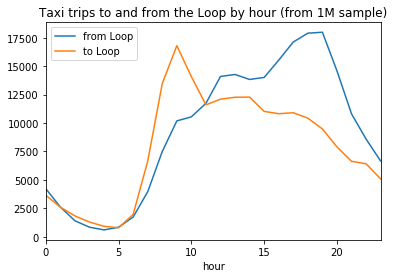

In [15]:
df_Loop[df_Loop['Pickup Community Area'] == 32.].groupby(df_Loop.hour).count()['Trip ID'].plot(label='from Loop')
df_Loop[df_Loop['Dropoff Community Area'] == 32.].groupby(df_Loop.hour).count()['Trip ID'].plot(label='to Loop')
plt.title('Taxi trips to and from the Loop by hour (from 1M sample)')
plt.legend()
plt.savefig('Figs/taxis_by_hour.png')
plt.show()

Again, we see the morning rush (peak at 9) and afternoon/evening rush (broad peak at 16-19). Consistent with common sense, the morning peak is traffic to the Loop, and the afternoon peak is traffic from the Loop.

Next, I'll focus on the evening rush, and look at where the trips are going.

In [16]:
#Keep only hour from 16 to 18 (this goes until 18:59).
df_eve_rush = df_Loop[(df_Loop.hour >= 16) & (df_Loop.hour <= 18)]

In [17]:
#How many are pickups?
print(len(df_eve_rush[df_eve_rush['Pickup Community Area'] == 32]))
#Where do they go?
df_eve_rush[df_eve_rush['Pickup Community Area'] == 32].groupby('Dropoff Community Area').count()['Trip ID']

50541


Dropoff Community Area
1.0        46
2.0        50
3.0       326
4.0       113
5.0       239
6.0      1591
7.0      2178
8.0     18214
9.0         1
10.0       10
11.0        4
12.0        6
13.0       11
14.0       32
15.0       26
16.0       65
17.0        3
18.0        1
19.0        6
20.0        1
21.0       62
22.0      357
23.0       19
24.0     1447
25.0        8
26.0        7
27.0       17
28.0     8726
29.0       37
30.0       14
        ...  
41.0      150
42.0       17
43.0       23
44.0        5
46.0        2
47.0        1
48.0        1
49.0        2
50.0        1
51.0        2
56.0      613
57.0        2
58.0       11
59.0       15
60.0       89
61.0        5
62.0        1
63.0        1
64.0        1
65.0        3
66.0        3
67.0        3
68.0        5
69.0        7
70.0        5
72.0        5
73.0        1
75.0        3
76.0     1839
77.0      209
Name: Trip ID, Length: 70, dtype: int64

In [18]:
#How many are dropoffs?
print(len(df_eve_rush[df_eve_rush['Dropoff Community Area'] == 32]))
#Where do they go?
df_eve_rush[df_eve_rush['Dropoff Community Area'] == 32].groupby('Pickup Community Area').count()['Trip ID']

32142


Pickup Community Area
1.0         9
2.0         8
3.0       101
4.0        18
5.0        32
6.0       516
7.0       584
8.0     11983
10.0        2
11.0        2
13.0        2
14.0        6
15.0        5
16.0        8
20.0        1
21.0       12
22.0       47
23.0        2
24.0      300
27.0        4
28.0     3236
29.0        2
31.0       15
32.0    10866
33.0     1607
34.0       25
35.0       26
36.0        1
38.0        1
39.0       18
40.0        3
41.0      200
42.0        5
43.0        2
44.0        1
56.0      506
59.0        5
60.0        7
61.0        1
62.0        2
65.0        1
69.0        3
70.0        1
76.0     1743
77.0       61
Name: Trip ID, dtype: int64

These would be easier to understand using maps. Use geopandas to draw them.

Boundaries for Community Areas are given at https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6.

In [19]:
import geopandas

In [20]:
chi_map = geopandas.read_file('Data/Boundaries - Community Areas (current).geojson')
#Make area_num_1 int and thne the index, as that's all I use to id them
chi_map['area_num_1'] = chi_map['area_num_1'].astype(int)
chi_map = chi_map.set_index(chi_map.area_num_1)

In [21]:
#Make column for how many trips there are to/from the Loop
df_to_Loop = df_eve_rush[df_eve_rush['Dropoff Community Area'] == 32].groupby('Pickup Community Area').count()['Trip ID']
df_from_Loop = df_eve_rush[df_eve_rush['Pickup Community Area'] == 32].groupby('Dropoff Community Area').count()['Trip ID']


In [22]:
chi_map['To_Loop'] = df_to_Loop
chi_map['From_Loop'] = df_from_Loop

chi_map[['To_Loop', 'From_Loop']] = chi_map[['To_Loop', 'From_Loop']].fillna(0)

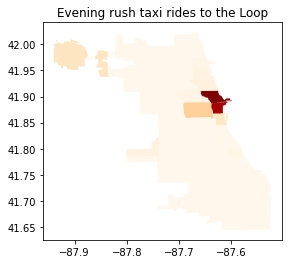

In [23]:
chi_map.plot(column='To_Loop', cmap='OrRd')
plt.title('Evening rush taxi rides to the Loop')
plt.savefig('Figs/evening_taxi_to_Loop.png')
plt.show()

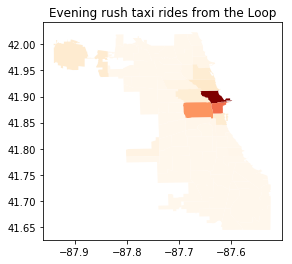

In [24]:
chi_map.plot(column='From_Loop', cmap='OrRd')
plt.title('Evening rush taxi rides from the Loop')
plt.savefig('Figs/evening_taxi_from_Loop.png')
plt.show()

The taxi usage to and from the Loop is heavily concentrated within the Loop and nearby areas, especially Near North and Near West. There is also some cabs to and from O'Hare Airport, which is in the northwest corner.

This is promising for any kind of road pricing scheme, because Near North and Near West are areas that are well-serviced by public transport, with multiple 'L' lines and numerous bus lines. It appears that people are taking taxis for speed and convenience, and not because the destinations are inaccessible by public transport.

## How much are passengers paying for the rides?
From the previous plots, it can be expected that the taxi fares are not very high on average.

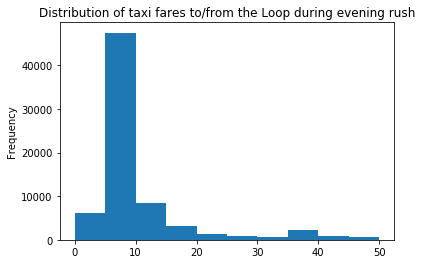

In [25]:
df_eve_rush['Fare'][df_eve_rush.Fare <= 50].plot.hist() #There are some outliers with very high fares
plt.title('Distribution of taxi fares to/from the Loop during evening rush')
plt.savefig('Figs/taxi_fare_hist.png')
plt.show()

There is a huge peak in the range \$5-10, and a full 3/4 of all taxi rides to and from the Loop during the rush have fares less than \$10. This suggests that even a small increase in the cost of using Loop streets at those hours could have a significant impact on the use of taxis (and by proxy, Uber and Lyft).

The small peak between \$35-40 is for O'Hare.

## Data cleaning
The bus tracking data has some major glitches. I'll show what the problems are and see how to limit ourselves to reliable part of the data. First, categorize the data by year and by hour.

In [137]:
df_cong.groupby(['year', 'hour']).count()

TIME  REGION_ID  BUS COUNT  \
year hour                                  
2013 23    1431556    1431556    1431556   
2014 23    1489556    1489556    1489556   
2015 0        5394       5394       5394   
     1        5394       5394       5394   
     2        5394       5394       5394   
     3        5394       5394       5394   
     4        5394       5394       5394   
     5        5394       5394       5394   
     6        5394       5394       5394   
     7        5394       5394       5394   
     8        5394       5394       5394   
     9        5394       5394       5394   
     10       5394       5394       5394   
     11       5394       5394       5394   
     12       5394       5394       5394   
     13       5394       5394       5394   
     14       5394       5394       5394   
     15       5394       5394       5394   
     16       5394       5394       5394   
     17       5394       5394       5394   
     18       5394       5394       5394   
     19       5394       5394       5394   
     20       5394       5394       5394   
     21       5365       5365       5365   
     22       5394       5394       5394   
     23     134821     134821     134821   

           NUMBER OF READS                          SPEED       ID  weekday  \
year hour                                                                     
2013 23                                  1431556  1431556  1431556  1431556   
2014 23                                  1489556  1489556  1489556  1489556   
2015 0                                      5394     5394     5394     5394   
     1                                      5394     5394     5394     5394   
     2                                      5394     5394     5394     5394   
     3                                      5394     5394     5394     5394   
     4                                      5394     5394     5394     5394   
     5                                      5394     5394     5394     5394   
     6                                      5394     5394     5394     5394   
     7                                      5394     5394     5394     5394   
     8                                      5394     5394     5394     5394   
     9                                      5394     5394     5394     5394   
     10                                     5394     5394     5394     5394   
     11                                     5394     5394     5394     5394   
     12                                     5394     5394     5394     5394   
     13                                     5394     5394     5394     5394   
     14                                     5394     5394     5394     5394   
     15                                     5394     5394     5394     5394   
     16                                     5394     5394     5394     5394   
     17                                     5394     5394     5394     5394   
     18                                     5394     5394     5394     5394   
     19                                     5394     5394     5394     5394   
     20                                     5394     5394     5394     5394   
     21                                     5365     5365     5365     5365   
     22                                     5394     5394     5394     5394   
     23                                   134821   134821   134821   134821   

             month      day  
year hour                    
2013 23    1431556  1431556  
2014 23    1489556  1489556  
2015 0        5394     5394  
     1        5394     5394  
     2        5394     5394  
     3        5394     5394  
     4        5394     5394  
     5        5394     5394  
     6        5394     5394  
     7        5394     5394  
     8        5394     5394  
     9        5394     5394  
     10       5394     5394  
     11       5394     5394  
     12       5394     5394  
     13       5394     5394  
     14       5394     5394 

This shows that all of 2013 and 2014 data are categorized as coming from hour 23 in the day (actually 23:50:26). And 2015 has the same problem for parts of the data.

In [96]:
#Put in columns for month and day
df_cong['month'] = df_cong['TIME'].apply(lambda x: x.month)
df_cong['day'] = df_cong['TIME'].apply(lambda x: x.day)

In [139]:
df_cong.groupby(['year', 'month']).count()

TIME  REGION_ID  BUS COUNT  \
year month                                 
2013 1       58087      58087      58087   
     2      116899     116899     116899   
     3      125947     125947     125947   
     4      123424     123424     123424   
     5      129253     129253     129253   
     6      120089     120089     120089   
     7      128905     128905     128905   
     8      122467     122467     122467   
     9      123511     123511     123511   
     10     129369     129369     129369   
     11     124149     124149     124149   
     12     129456     129456     129456   
2014 1      128296     128296     128296   
     2       92771      92771      92771   
     3      128615     128615     128615   
     4      125222     125222     125222   
     5      128905     128905     128905   
     6      125251     125251     125251   
     7      129224     129224     129224   
     8      129456     129456     129456   
     9      123453     123453     123453   
     10     128383     128383     128383   
     11     125454     125454     125454   
     12     124526     124526     124526   
2015 1      258854     258854     258854   

            NUMBER OF READS                         SPEED      ID    hour  \
year month                                                                  
2013 1                                      58087   58087   58087   58087   
     2                                     116899  116899  116899  116899   
     3                                     125947  125947  125947  125947   
     4                                     123424  123424  123424  123424   
     5                                     129253  129253  129253  129253   
     6                                     120089  120089  120089  120089   
     7                                     128905  128905  128905  128905   
     8                                     122467  122467  122467  122467   
     9                                     123511  123511  123511  123511   
     10                                    129369  129369  129369  129369   
     11                                    124149  124149  124149  124149   
     12                                    129456  129456  129456  129456   
2014 1                                     128296  128296  128296  128296   
     2                                      92771   92771   92771   92771   
     3                                     128615  128615  128615  128615   
     4                                     125222  125222  125222  125222   
     5                                     128905  128905  128905  128905   
     6                                     125251  125251  125251  125251   
     7                                     129224  129224  129224  129224   
     8                                     129456  129456  129456  129456   
     9                                     123453  123453  123453  123453   
     10                                    128383  128383  128383  128383   
     11                                    125454  125454  125454  125454   
     12                                    124526  124526  124526  124526   
2015 1                                     258854  258854  258854  258854   

            weekday     day  
year month                   
2013 1        58087   58087  
     2       116899  116899  
     3       125947  125947  
     4       123424  123424  
     5       129253  129253  
     6       120089  120089  
     7       128905  128905  
     8       122467  122467  
     9       123511  123511  
     10      129369  129369  
     11      124149  124149  
     12      129456  129456  
2014 1       128296  128296  
     2        92771   92771  
     3       128615  128615  
     4       125222  125222  
     5       128905  128905  
     6       125251  125251  
     7       129224  129224  
     8       129456  129456  
     9       123453  123453  
     10      128383  128383  
     11      125454  1254

In [142]:
df_cong[df_cong['year'] == 2013].groupby('day').count()

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID,year,hour,weekday,month
day,,,,,,,,,,
1,45936,45936,45936,45936,45936,45936,45936,45936,45936,45936
2,45936,45936,45936,45936,45936,45936,45936,45936,45936,45936
3,45414,45414,45414,45414,45414,45414,45414,45414,45414,45414
4,44341,44341,44341,44341,44341,44341,44341,44341,44341,44341
5,45936,45936,45936,45936,45936,45936,45936,45936,45936,45936
6,45936,45936,45936,45936,45936,45936,45936,45936,45936,45936
7,45733,45733,45733,45733,45733,45733,45733,45733,45733,45733
8,45936,45936,45936,45936,45936,45936,45936,45936,45936,45936
9,45936,45936,45936,45936,45936,45936,45936,45936,45936,45936


In [143]:
df_cong[df_cong['year'] == 2014].groupby('day').count()

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID,year,hour,weekday,month
day,,,,,,,,,,
1,50083,50083,50083,50083,50083,50083,50083,50083,50083,50083
2,49619,49619,49619,49619,49619,49619,49619,49619,49619,49619
3,49387,49387,49387,49387,49387,49387,49387,49387,49387,49387
4,49909,49909,49909,49909,49909,49909,49909,49909,49909,49909
5,49880,49880,49880,49880,49880,49880,49880,49880,49880,49880
6,50112,50112,50112,50112,50112,50112,50112,50112,50112,50112
7,50083,50083,50083,50083,50083,50083,50083,50083,50083,50083
8,50054,50054,50054,50054,50054,50054,50054,50054,50054,50054
9,49938,49938,49938,49938,49938,49938,49938,49938,49938,49938


2013 and 2014 data do seem to have mostly the correct date information. If I can figure out the ordering of the readings within a day, they would be useful.

The reason 2015 only has January data is because the data stopped being updated in February.

Leaving the weird part of the data set aside for now, look at the part that looks fine.

In [114]:
df_cong[(df_cong['year'] == 2015) & (df_cong['day'] == 1) & 
        (df_cong['hour'] == 0) & (df_cong['REGION_ID'] == 13)]

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID,year,hour,weekday,month,day
39062,2015-01-01 00:20:47,13,26,343,21.14,e89acc9cef614ebeaa3a15024137348610a03bce,2015,0,True,1,1
48663,2015-01-01 00:01:17,13,25,327,23.18,47490683c4ec8df2defe85ae1e9f41d6fd5bda06,2015,0,True,1,1
83534,2015-01-01 00:40:14,13,31,433,18.41,e0f7a457bd98cb0173b2c93d47ee61be26f76b51,2015,0,True,1,1
86527,2015-01-01 00:31:02,13,26,347,19.77,381e22cfa943ef8d22750e9cd45055c3850031a2,2015,0,True,1,1
121100,2015-01-01 00:50:26,13,30,506,19.09,bfe37d67ff1e763d2bf0f3165fe1bc8ac0de8e27,2015,0,True,1,1
123450,2015-01-01 00:10:26,13,18,251,22.50,48ee17e96bb7bae7fef46236f7bc2d07a51677df,2015,0,True,1,1


There's a reading once every 10 minutes. This explains the number of readings for every hour except 21st (with slightly fewer rows than there should be) and 23rd (with many times more).

5394 = 31 (days) $\times$ 6 $\times$ 29 (regions)

Look at hour 21.

In [125]:
df_cong[(df_cong['year'] == 2015) & 
        (df_cong['hour'] == 21) & (df_cong['REGION_ID'] == 13)].groupby('day').count()

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID,year,hour,weekday,month
day,,,,,,,,,,
1,6,6,6,6,6,6,6,6,6,6
2,6,6,6,6,6,6,6,6,6,6
3,6,6,6,6,6,6,6,6,6,6
4,6,6,6,6,6,6,6,6,6,6
5,6,6,6,6,6,6,6,6,6,6
6,6,6,6,6,6,6,6,6,6,6
7,6,6,6,6,6,6,6,6,6,6
8,6,6,6,6,6,6,6,6,6,6
9,6,6,6,6,6,6,6,6,6,6


2015-01-22 is missing a value.

In [126]:
df_cong[(df_cong['year'] == 2015) & 
        (df_cong['hour'] == 21) & (df_cong['day'] == 22) & (df_cong['REGION_ID'] == 13)]

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID,year,hour,weekday,month,day
34065,2015-01-22 21:20:56,13,49,700,17.05,130e19038a9cdc3cb2d231c83217c31de9b47fdb,2015,21,True,1,22
44414,2015-01-22 21:10:41,13,56,855,16.36,bd25b745bff00ca8f69048c7c897242ead0c6cf5,2015,21,True,1,22
103309,2015-01-22 21:40:21,13,51,742,16.36,8dd14373518559f5307bf318609bc38fbdf53181,2015,21,True,1,22
106984,2015-01-22 21:01:33,13,54,728,16.36,d56296b940c15dadb187744cf2401f2fba3ea999,2015,21,True,1,22
109809,2015-01-22 21:31:10,13,50,726,15.68,8d71816a53c9b4d78a26576907938f3bb572510a,2015,21,True,1,22


2015-01-22 21:50 values are missing. This seems to be a minor problem.

Look at hour 23.

In [130]:
df_cong[(df_cong['year'] == 2015) & 
        (df_cong['hour'] == 23) & (df_cong['REGION_ID'] == 13)].groupby('day').count()

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID,year,hour,weekday,month
day,,,,,,,,,,
1,150,150,150,150,150,150,150,150,150,150
2,150,150,150,150,150,150,150,150,150,150
3,150,150,150,150,150,150,150,150,150,150
4,150,150,150,150,150,150,150,150,150,150
5,150,150,150,150,150,150,150,150,150,150
6,150,150,150,150,150,150,150,150,150,150
7,150,150,150,150,150,150,150,150,150,150
8,150,150,150,150,150,150,150,150,150,150
9,150,150,150,150,150,150,150,150,150,150


There's 150 rows instead of 6. This is too much by a factor of 25.

In [147]:
df_cong[(df_cong['year'] == 2015) & 
        (df_cong['hour'] == 23) & (df_cong['REGION_ID'] == 13)
        & (df_cong['day'] == 1) & (df_cong['BUS COUNT'] == 25)]

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID,year,hour,weekday,month,day
86877,2015-01-01 23:50:26,13,25,346,23.18,a841fda1cc98308545280795dc628ddb919852eb,2015,23,True,1,1
98988,2015-01-01 23:40:15,13,25,321,23.18,3cc423ccfa66759232460e781fb819e0531a724d,2015,23,True,1,1
254690,2015-01-01 23:50:26,13,25,346,23.18,5a6e8208ab9b0ba56dead87edb3b6a6ef4026352,2015,23,True,1,1
254719,2015-01-01 23:50:26,13,25,321,23.18,c5e16e4a20a27ed33120ede3f13c4e48ecfff3ec,2015,23,True,1,1
257706,2015-01-01 23:50:26,13,25,370,23.18,23fdce8d3c4ee6b1b07d959661cfd536ab9df5d1,2015,23,True,1,1
258837,2015-01-01 23:50:26,13,25,327,23.18,79a6ca3b1387a66cb2b45ad65b0915139b9276dc,2015,23,True,1,1


It seems that there are some duplicates (middle 2 in the last output), and also some that I can't make sense of (bottom 2).

In any case, the number of rows from January 2015 that seem to make sense is

In [151]:
5394*24-29

129427

All the rows from 129427 have hour 23.

In [158]:
df_cong.iloc[129427:].groupby('hour').count()

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID,year,weekday,month,day
hour,,,,,,,,,,
23,3050539,3050539,3050539,3050539,3050539,3050539,3050539,3050539,3050539,3050539


Everything before that, I expect to be clean.

In [174]:
df_cong.iloc[:129427].groupby('hour').count()

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID,year,weekday,month,day
hour,,,,,,,,,,
0,5394,5394,5394,5394,5394,5394,5394,5394,5394,5394
1,5394,5394,5394,5394,5394,5394,5394,5394,5394,5394
2,5394,5394,5394,5394,5394,5394,5394,5394,5394,5394
3,5394,5394,5394,5394,5394,5394,5394,5394,5394,5394
4,5394,5394,5394,5394,5394,5394,5394,5394,5394,5394
5,5394,5394,5394,5394,5394,5394,5394,5394,5394,5394
6,5394,5394,5394,5394,5394,5394,5394,5394,5394,5394
7,5394,5394,5394,5394,5394,5394,5394,5394,5394,5394
8,5394,5394,5394,5394,5394,5394,5394,5394,5394,5394
